# Fashion Dataset
a notebook to explore the [Fashion product images dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset) in order to prepare a `Dataset` class and `Dataloader` 

Some ideas for what we can do with the dataset, taken from the dataset page:
- Start with an image classifier. Use the masterCategory column from styles.csv and train a convolutional neural network.
- The same can be achieved via NLP. Extract the product descriptions from styles/42431.json and then run a classifier to get the masterCategory.
- Try adding more sophisticated classification by predicting the other category labels in styles.csv   

Transfer Learning is your friend and use it wisely.  

You can even take things much further from here:
- Is it possible to build a GAN that takes a category as input and outputs an image?
- Auto-encode the image attributes to be able to make a visual search engine that converts the image into a small encoding which is sent to the server to perform visual search?
- Visual similarity search? Given an image, suggest other similar images.


In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from glob import glob as Glob
import json
%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)
!which python

/bin/bash: /home/guy/anaconda3/envs/dis_ir/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/guy/anaconda3/envs/dis_ir/bin/python


In [2]:
# option 1 to handle images 
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    if isinstance(imgs[0],str):
        imgs=[Image.open(i) for i in imgs]
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# Exploration

In [3]:
dataset_path = '/home/guy/sd1tb/datasets/fashion-dataset'

os.listdir(dataset_path)

['images', 'styles', 'styles.csv', 'images.csv']

In [4]:
# option 2 to handle images
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return dataset_path+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

## Annotations

### high level annotation

In [5]:
df = pd.read_csv(dataset_path + "/styles.csv",on_bad_lines='skip')
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   
5   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
6  30805    Men        Apparel     Topwear       Shirts      Green  Summer   
7  26960  Women        Apparel     Topwear       Shirts     Purple  Summer   
8  29114    Men    Accessories       Socks        Socks  Navy Blue  Summer   
9  30039    Men    Accessories     Watches      Watches      Black  Winter   

     year   usage                             productDisplayName      image  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  15970.jpg  
1  2012.0  Casual             Peter England Men Party Blue Jeans  39386.jpg  
2  2016.0  Casual                       Titan Women Silver Watch  59263.jpg  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  21379.jpg  
4  2012.0  Casual                          Puma Men Grey T-shirt  53759.jpg  
5  2011.0  Casual           Inkfruit Mens Chain Reaction T-shirt   1855.jpg  
6  2012.0  Ethnic               Fabindia Men Striped Green Shirt  30805.jpg  
7  2012.0  Casual                  Jealous 21 Women Purple Shirt  26960.jpg  
8  2012.0  Casual                       Puma Men Pack of 3 Socks  29114.jpg  
9  2016.0  Casual                         Skagen Men Black Watch  30039.jpg

In [6]:
df.shape

(44424, 11)

In [ ]:
cat_cols=['gender','masterCategory','subCategory','articleType','baseColour','season','usage']

{c:len(df[c].value_counts()) for c in cat_cols}

there are some categorical variables with many possible values . specifically `articleType`

In [20]:
df['articleType'].unique()

array(['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks',
       'Casual Shoes', 'Belts', 'Flip Flops', 'Handbags', 'Tops', 'Bra',
       'Sandals', 'Shoe Accessories', 'Sweatshirts', 'Deodorant',
       'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas',
       'Waistcoat', 'Sports Shoes', 'Shorts', 'Briefs', 'Sarees',
       'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests',
       'Pendant', 'Nail Polish', 'Laptop Bag', 'Scarves', 'Rain Jacket',
       'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring',
       'Kurta Sets', 'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers',
       'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta',
       'Capris', 'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics',
       'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser',
       'Necklace and Chains', 'Duffel Bag', 'Sports Sandals',
       'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag',
       'Tracksuits', 'S

In [ ]:
df['subCategory'].unique()

### Detailed annotation
Note that each article has a corresponding `.json` file with additional description on its style.

In [ ]:
style_path = os.path.join(dataset_path,'styles')
style_jsons = os.listdir(style_path)
print(len(style_jsons))
style_jsons[:10]

Lets check the style for one of the articles

In [ ]:
aid = df.loc[1,'id']
with open(os.path.join(style_path,str(aid)+'.json')) as f:
    ast = json.load(f)
ast

In [ ]:
ast.keys()

most of the information is in the `data` dictionary:

In [ ]:
ast['data'].keys()

## images

In [5]:
img_fn=[i for i in Glob(f'{dataset_path}/images/*.jpg',recursive=True)]
len(img_fn)

44441

In [6]:
imsz = [Image.open(im).size for im in img_fn]

# plt.imshow(img)

In [7]:
pd.Series(imsz).value_counts()

(1080, 1440)    24459
(1800, 2400)    19721
(150, 200)        119
(360, 480)         60
(540, 720)         21
(1200, 1600)        8
(2250, 3000)        4
(2700, 2700)        4
(3744, 5616)        3
(3456, 5184)        2
(1800, 2401)        2
(1799, 2400)        2
(2425, 3233)        2
(2355, 3140)        2
(2759, 3678)        2
(1800, 2297)        2
(2774, 3698)        1
(2711, 3615)        1
(1087, 1446)        1
(2395, 3193)        1
(2304, 2920)        1
(2444, 3259)        1
(480, 640)          1
(2136, 3216)        1
(2510, 3347)        1
(2592, 3888)        1
(2448, 3264)        1
(2411, 3214)        1
(2804, 3739)        1
(1101, 1456)        1
(2500, 3333)        1
(2848, 4288)        1
(800, 800)          1
(2442, 3256)        1
(514, 644)          1
(1800, 2399)        1
(1500, 2000)        1
(2652, 3536)        1
(683, 1024)         1
(1350, 1800)        1
(1806, 2700)        1
(1097, 1453)        1
(1354, 2020)        1
(1080, 1620)        1
dtype: int64

In [ ]:
# find image with a given size
im=[img_fn[i] for i in range(len(img_fn)) if imsz[i] == (480,640) ]
Image.open(im[0])

In [ ]:
# resize the images with a limit on each axis size, while maintaining aspect ratio
size=(256,256)
imgs = [Image.open(im) for im in img_fn]
[i.thumbnail(size) for i in imgs]
[im.size for im in imgs]

In [ ]:
# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

### get images by annotation

In [8]:
def get_imgs_by_key_val(key,val):
    imgs=df.loc[df[key]==val,'image'].values
    imgs=[dataset_path+'/images/'+i for i in imgs]
    print(f'found {len(imgs)} images')
    return imgs

In [18]:
key='articleType'
# val='Nightdress'
val = 'Casual Shoes'
imgs_names=get_imgs_by_key_val(key,val)

found 2845 images


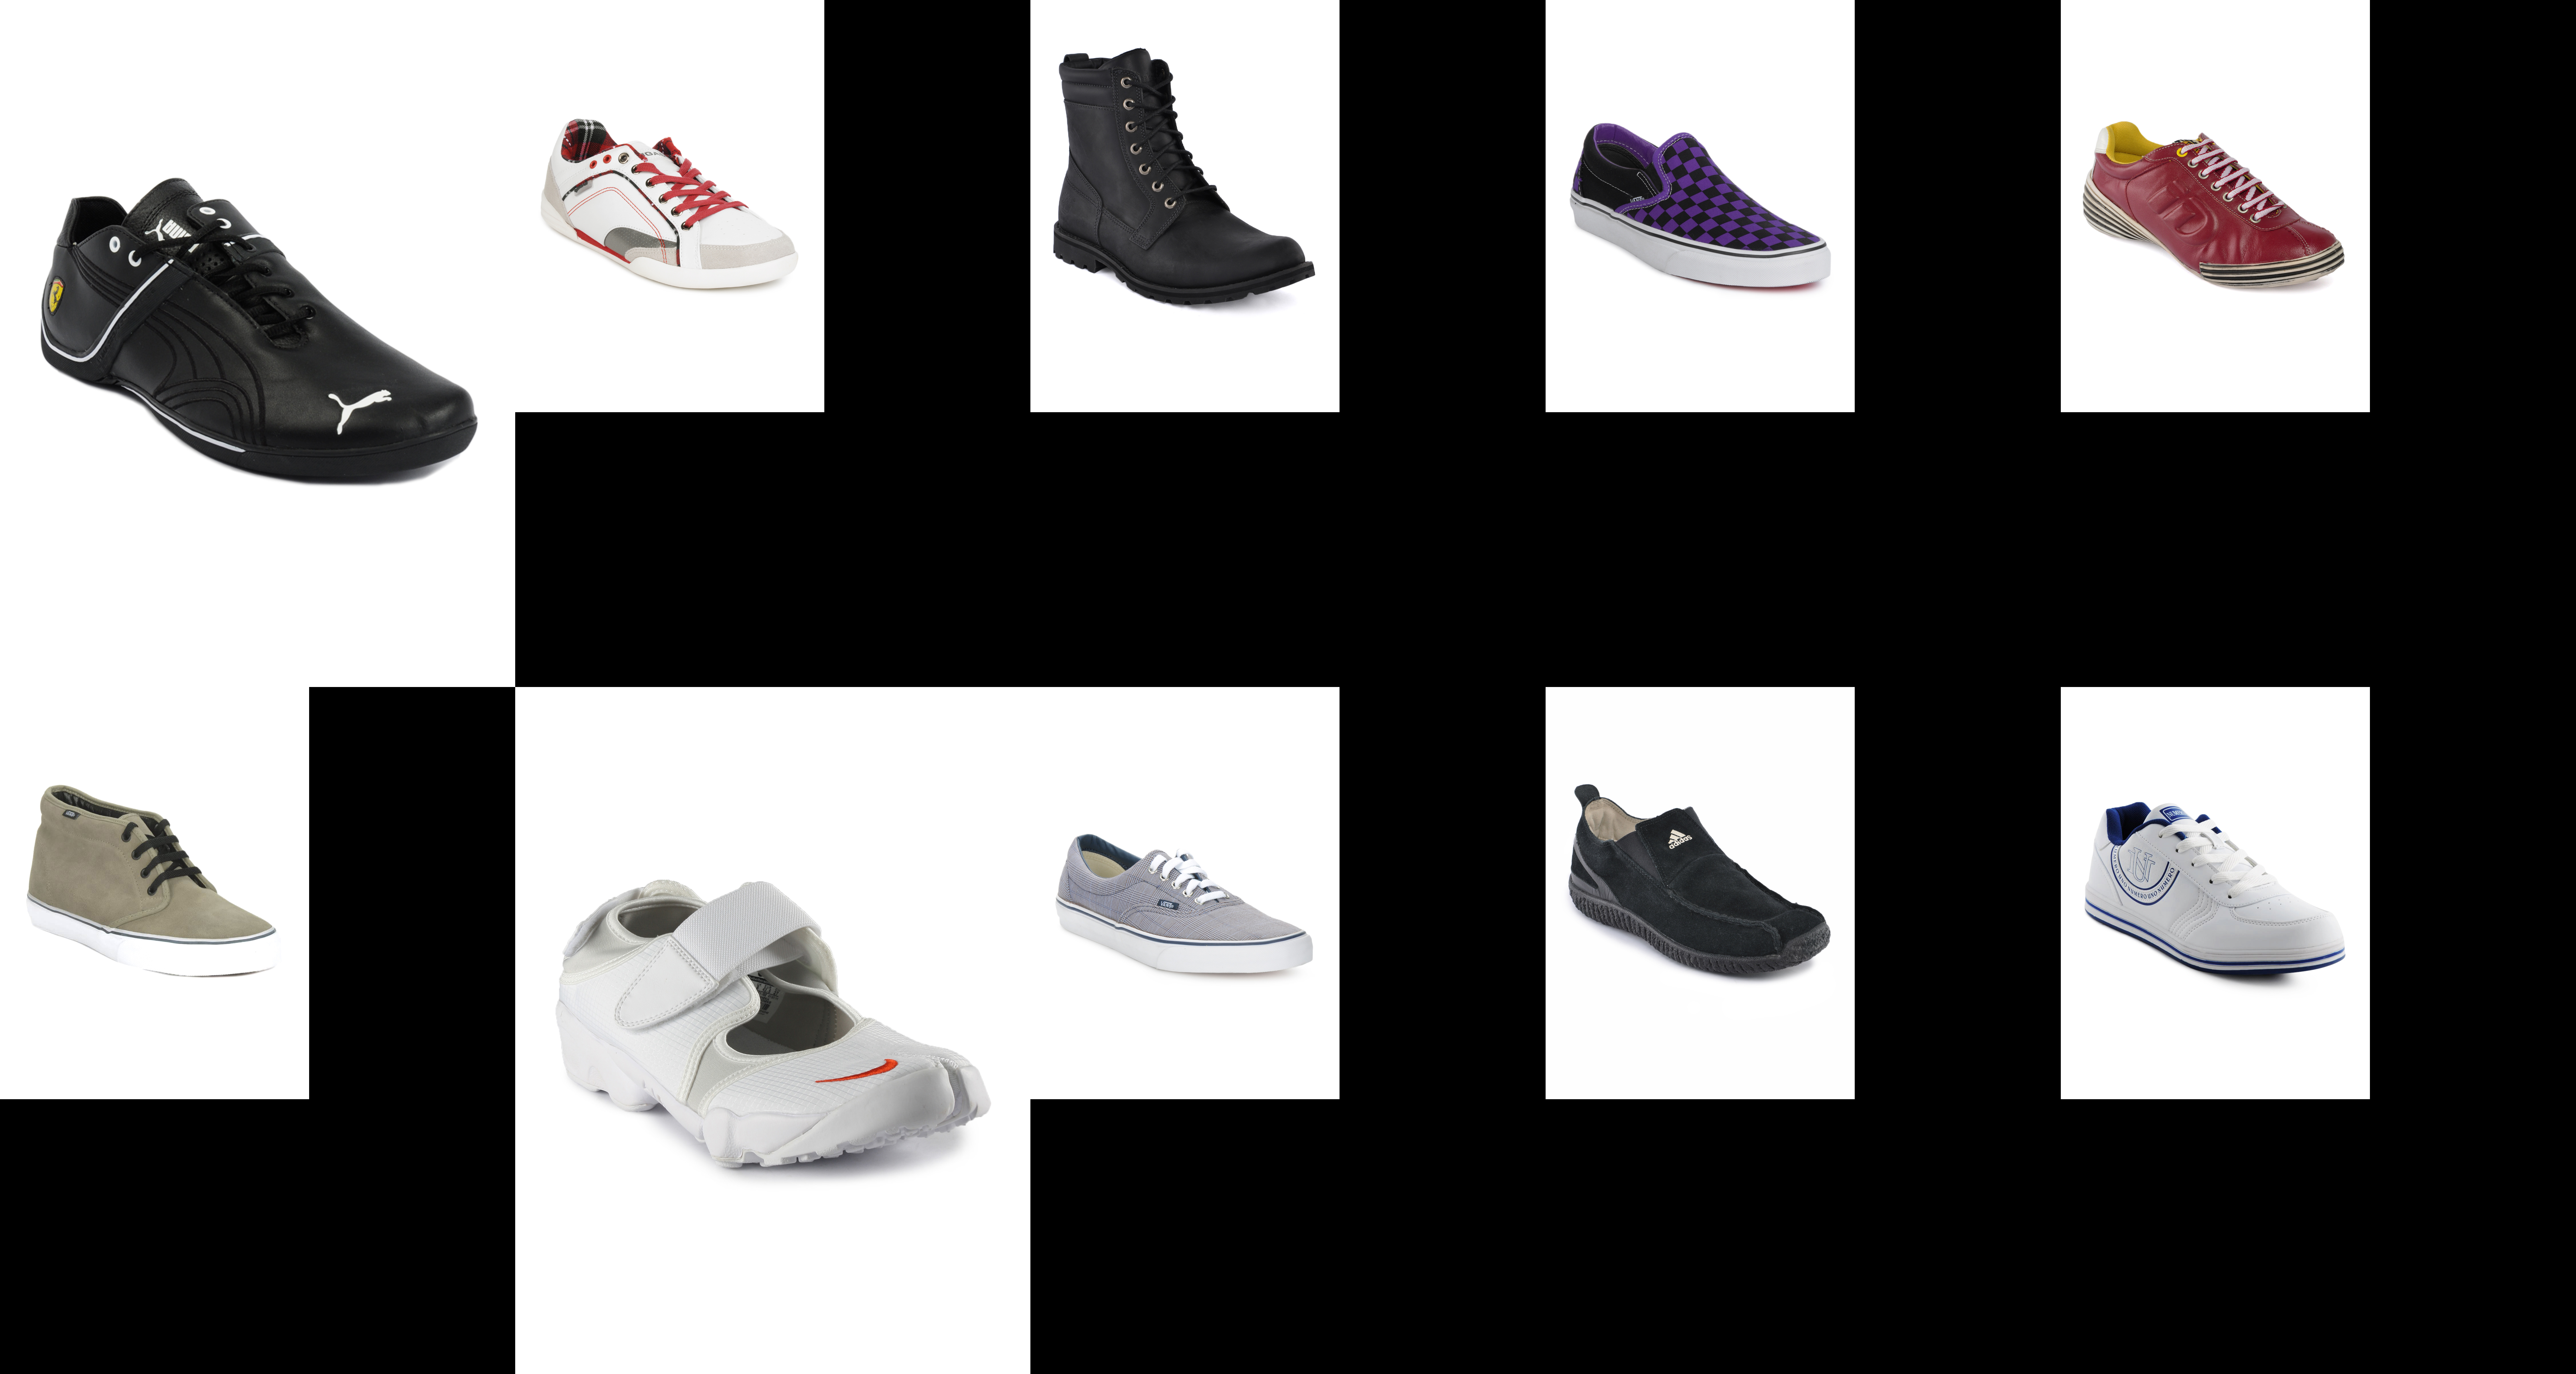

In [19]:
image_grid(imgs_names[:10],2,5)

# Preprocess Dataset
The goal is to create a folder that is a duplicate of the original dataset in structure, but where the images are already preprocessed in order to save the time during training.
any deterministic operation that doesnt harm any future augmentation should be done in this stage 

# Dataset Class
The goal is to prepare a dataset class and dataloader that we can use to train the VAE.
we can use the code from the `Text2Human` repo

here's another [repo](https://github.com/ihciah/deep-fashion-retrieval) that uses the datasets.

and here's another repo from the authors of DeepFashion: [mmfashion](https://github.com/open-mmlab/mmfashion)
in that repo, look at the [In_shop.py](https://github.com/open-mmlab/mmfashion/blob/master/mmfashion/datasets/In_shop.py) file


In [ ]:
import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

## Dataset Normalization
in order to normalize the dataset, we could either use the pytorch official normalization statistics as derived from ImageNet (see [this discussion](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)):  
`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` 

but we might want to compute the statistics by ourselves as the images in this dataset are not that natural. they all have a clean background.
for that, lets define the dataset class without the normalization and then compute its stats

In [ ]:
trn_tfms = T.Compose([
#     T.ToPILImage(),
    #---------comment out data augmentation------
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    #---------------------------------------------
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
#     T.ToPILImage(),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])



class DeepFashion(Dataset):
    """DeepFashion dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
#         clss = fname(parent(fpath))  # todo: read the label/attributes
        img = read_image(fpath)/255.0
        # return a dummy label at this stage as it doesnt matter
        return img,1

    def choose(self):
        return self[np.random.randint(len(self))]

    # def collate_fn(self, batch):
    #     imgs, classes = list(zip(*batch))
    #     if self.transform:
    #         imgs = [self.transform(img)[None] for img in imgs]
    #     classes = [torch.tensor([id2int[clss]]) for clss in classes]
    #     imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    #     return imgs, classes

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        return imgs


dataset = DeepFashion(img_fn,trn_tfms)
loader = DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False)

In [ ]:
batch=next(iter(loader))
b,c,h,w=next(iter(loader))[0].shape
print(b,c,h,w)

In [ ]:
T.ToPILImage()(batch[0][1])


once we have the dataset defined we can compute the stats as follows ([reference](https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949))

In [ ]:
# get dataset statistics. to be used for normalizing the dataset
# h,w=next(iter(loader))[0].shape[2:]
mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*h*w))


print(f'mean:{mean},std:{std}')

## Dataset Class definition
now that we have the dataset statistics we can create a dataset that normalizes appropriately.


In [ ]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
    #             std=[0.2332, 0.2500, 0.2564]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
    #             std=[0.2332, 0.2500, 0.2564]),
])

class DeepFashion(Dataset):
    """DeepFashion dataset."""

    def __init__(self, dataset_path, split='train',transform=None):
        self.files=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] 
        # read item attributes:
        # the attribute can be the cloth attribute or it can be viewing angle or type of item (based on the folder)
        # in the following example, we're taking the cloth attributes (463 attributes)
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
        with open(anno_filename,'r') as f:
            attr_items=f.read().splitlines()
        attr_items=attr_items[2:]
        attr_items=[i.split() for i in attr_items]
        self.attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
        # get attributes names
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
        with open(anno_filename,'r') as f:
            attr_cloth=f.read().splitlines()
        self.attr_names = attr_cloth[2:]

        # split the dataset and throw the irrelevant part
        train_fraction=0.8
        train_size = int(train_fraction* len(self.attr_items.keys()))

        if split=='train':
            self.files = self.files[:train_size]
        else:
            self.files = self.files[train_size:]

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        lbl=self.attr_items[fpath.split('/')[-2]]
        img = read_image(fpath)/255.0
        return img,lbl

    def choose(self):
        return self[np.random.randint(len(self))]


    def collate_fn(self, batch):
        imgs, attrs = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        else:
            imgs = [img[None] for img in imgs]
        attrs=[torch.tensor(a)[None] for a in attrs]
        imgs,attrs = [torch.cat(i) for i in [imgs,attrs]]
        return imgs,attrs

dataset = DeepFashion(dataset_path,'train')
loader = DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False,collate_fn=dataset.collate_fn)

In [ ]:
dataset.files[:10]

In [ ]:
batch=next(iter(loader))
b,c,h,w=batch[0].shape
print(b,c,h,w)
print(batch[1].shape)

In [ ]:
T.ToPILImage()(batch[0][3])

In [ ]:
batch[1][0].shape

# Draft

## CelebA
this is the dataset considered as a baseline

### explore the images

In [ ]:
clba_path = '/home/guy/sd1tb/datasets/CelebA/celeba/img_align_celeba'
# clba_path = '/data/users/gkoren2/datasets/celeba/celeba/img_align_celeba'   # gpu15
imgs_filenames=os.listdir(clba_path)
len(imgs_filenames)

In [ ]:
# extract image sizes and make sure they all at sime size
imsz = [Image.open(os.path.join(clba_path,im)).size for im in imgs_filenames]
np.all([s==imsz[0] for s in imsz])

Lets check the alignment by displaying the average of the images

In [ ]:
img_indxs = [i for i in range(1000)]
avg_img = np.zeros_like(Image.open(os.path.join(clba_path,imgs_filenames[0])),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(os.path.join(clba_path,imgs_filenames[idx]))
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

ok, we see that the images are pretty much aligned. this is something that should predict the successfulness of the VAE. 

In [ ]:
# to make a gif from the images:
img_indxs = [i for i in range(1000)]
imgs = (Image.open(os.path.join(clba_path,imgs_filenames[i])) for i in img_indxs)
img = next(imgs)  # extract first image from iterator
img.save(fp='celeba.gif', format='GIF', append_images=imgs,save_all=True, duration=20, loop=0)

### load CelebA dataset class
Lets import the dataset as it is done in the VAE s.t. we understand how to prepare `DeepFashion` dataset

In [ ]:
from torchvision.datasets import CelebA
import torch.utils.data as data
from torchvision import transforms as T
# clba_path = '/data/users/gkoren2/datasets/celeba/'   # gpu15
clba_path = '/home/guy/sd1tb/datasets/CelebA/'
patch_size=256
trn_tfms = T.Compose([      # copied from dataset.py 
    T.RandomHorizontalFlip(),
    T.CenterCrop(148),
    T.Resize(patch_size),
    T.ToTensor(),
    ])

clba = CelebA(clba_path, split='train',transform=trn_tfms,download=False)

dir(clba)


In [ ]:
getattr(clba,'collate_fn',None)

In [ ]:
clba_loader = data.DataLoader(clba,batch_size=10,num_workers=0,shuffle=False)
clba_batch=next(iter(clba_loader))

In [ ]:
print(clba_batch[0].shape)       # the images tensor
print(clba_batch[1].shape)       # the labels (attributes) tensor


In [ ]:
print(len(clba.attr_names))
clba.attr_names

In [ ]:
clba_batch[0].std()

it looks like the only normalization they have applied is scaling s.t. the value of the pixels are in [0,1]. they havent normalized it to `mean=0 , stdev=1`

In [ ]:
T.ToPILImage()(clba_batch[0][1])

In [ ]:
clba_batch[1][0].shape

In [ ]:
clba_batch[1][0]

## DeepFashion dataset


### In-Shop Clothes Retrieval

- Images (Img/img.zip):   52,712 in-shop clothes images (~200,000 cross-pose/scale pairs).
    - Images are centered and resized to 256*256;
    - The aspect ratios of original images are kept unchanged
- Bounding Box Annotations (Anno/list_bbox_inshop.txt)
- Fashion Landmark Annotations (Anno/list_landmarks_inshop.txt)
- Item Annotations (Anno/list_item_inshop.txt)
- Description Annotations (Anno/list_description_inshop.json)
- Attribute Annotations (Anno/attributes/list_attr_cloth.txt & Anno/attributes/list_attr_items.txt & Anno/attributes/list_color_cloth.txt)
- Segmentation Mask Annotations (Anno/segmentation/DeepFashion_instances_train.json & Anno/segmentation/DeepFashion_instances_query.json & Anno/segmentation/DeepFashion_instances_gallery.json)
- Dense Pose Annotations (Anno/densepose/img_iuv.zip)
- Evaluation Partitions (Eval/list_eval_partition.txt)


In [ ]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark' # gpu15
# benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
# benchmarks
os.listdir(dataset_path)

#### Annotations

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','list_item_inshop.txt')
with open(anno_filename,'r') as f:
    item_list=f.read().splitlines()

len(item_list)

In [ ]:
item_list[:10]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','list_description_inshop.json')
with open(anno_filename,'r') as f:
    item_desc = json.load(f)
desc_df=pd.DataFrame(item_desc)

In [ ]:
desc_df.head()

In [ ]:
desc_df.item.value_counts()

In [ ]:
desc_df.loc[desc_df['item']=='id_00000001',:]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
with open(anno_filename,'r') as f:
    attr_cloth=f.read().splitlines()
attr_cloth = attr_cloth[2:]
len(attr_cloth)

In [ ]:
attr_cloth[:10]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
with open(anno_filename,'r') as f:
    attr_items=f.read().splitlines()
attr_items=attr_items[2:]
attr_items=[i.split() for i in attr_items]
attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
len(attr_items)

In [ ]:
print(len(attr_items['id_00000013']))
attr_items['id_00000013']

Notes:
1. The order of attribute labels accords with the order of attribute names;
2. In attribute labels, "1" represents positive while "-1" represents negative, '0' represents unknown;
3. Attribute prediction is treated as a multi-label tagging problem.


In [ ]:
attr_item_desc={i[0]:[attr_cloth[ai] for ai in range(len(attr_cloth)) if i[ai+1]=='1'] for i in attr_items}

In [ ]:
attr_item_desc['id_00000013']

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_color_cloth.txt')
with open(anno_filename,'r') as f:
    color_cloth=f.read().splitlines()

len(color_cloth)

In [ ]:
color_cloth[:10]

#### Eval partitions

In [ ]:
eval_part_filename = os.path.join(dataset_path,'Eval','list_eval_partition.txt')
with open(eval_part_filename,'r') as f:
    eval_part_list=f.read().splitlines()
eval_part_list=eval_part_list[2:]
eval_part_list=[i.split() for i in eval_part_list]
eval_part_list = {i[1]:i[2] for i in eval_part_list}


In [ ]:
pd.DataFrame(eval_part_list.values()).value_counts()

In [ ]:
epl0=eval_part_list[2]
epl0.split()

#### Images

##### explore

In [ ]:
! tree "{os.path.join(dataset_path,'Img/img')}" -L 2

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
len(img_fn)

In [ ]:
# base name
img_bn=[s.split('img')[1] for s in img_fn]
len(img_bn)

In [ ]:
[f for f in img_fn if 'id_00003321' in f]

In [ ]:
! tree "{os.path.join(os.path.dirname(dataset_path),'img_highres')}" -L 2

In [ ]:
img_hres_fn = [i for i in Glob(f"{os.path.join(os.path.dirname(dataset_path),'img_highres')}/**/*.jpg",recursive=True)]
len(img_hres_fn)

In [ ]:
img_hres_fn[:10]

In [ ]:
img_hres_bn=[s.split('img_highres')[1] for s in img_hres_fn]
len(img_hres_bn)

In [ ]:
# comapre the names - make sure we have exact copy of each image as highres
np.all(np.array(img_bn)==np.array(img_hres_bn))

In [ ]:
# lets see an image and its highres variant
img_id = 2345
img = Image.open(img_fn[img_id])
img_hres=Image.open(img_hres_fn[img_id])
print(f'{img.size} , {img_hres.size}')


we'll ignore the high res images. look only at the low res

##### get item images

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
img_hres_fn = [i for i in Glob(f"{os.path.join(os.path.dirname(dataset_path),'img_highres')}/**/*.jpg",recursive=True)]

In [ ]:
def get_item_images(item_id,hres=False):
    img_fns=img_hres_fn if hres else img_fn
    img_filenames = [f for f in img_fns if item_id in f]
    if len(img_filenames)==0:
        print(f'item {item_id} not found')
        return None
    else:
        imgs = {os.path.basename(f):Image.open(f) for f in img_filenames}
        print(f'found {len(imgs)} for item {item_id}')
        return imgs

In [ ]:
imgs = get_item_images('id_00000002',False)
imgs

In [ ]:
image_grid(list(imgs.values()),2,2)

In [ ]:
# get image stats
img_indxs = [i for i in range(len(img_fn))]
avg_img = np.zeros_like(Image.open(img_fn[0]),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(img_fn[idx])
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
# Image.fromarray(np.uint8(avg_img))

In [ ]:
len(img_fn)

In [ ]:
img_fn[:10]

In [ ]:
img_fn[0].split('/')[-2]

In [ ]:
avg_img.shape

In [ ]:
avg_img[:,:,0].mean()/255

In [ ]:
ai1=avg_img.reshape([-1,3]).mean(axis=0)/255
ai1

In [ ]:
ai1-np.array([0.485, 0.456, 0.406])/np.array([0.229, 0.224, 0.225])

### Category and Attribute Prediction

- Images (Img/img.zip):  289,222 diverse clothes images. 
    - The long side of images are resized to 300;
    - The aspect ratios of original images are kept unchanged.
- Bounding Box Annotations (Anno/list_bbox.txt) bounding box labels. 
- Fashion Landmark Annotations (Anno/list_landmarks.txt) fashion landmark labels
- Category Annotations (Anno/list_category_cloth.txt & Anno/list_category_img.txt) clothing category labels. 
- Attribute Annotations (Anno/list_attr_cloth.txt & Anno/list_attr_img.txt) clothing attribute labels. 
- Evaluation Partitions (Eval/list_eval_partition.txt) image names for training, validation and testing set respectively.


In [ ]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction' # gpu15
# benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
# benchmarks
os.listdir(dataset_path)

#### Annotations

#### Images

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/img/**/*.jpg',recursive=True)] #  if 'side' in i]
img_hres_fn = [i for i in Glob(f"{os.path.join(dataset_path,'img_highres')}/**/*.jpg",recursive=True)]

In [ ]:
print(len(img_fn))
print(len(img_hres_fn))

In [ ]:
img_fn[:10]

In [ ]:
os.path.basename(os.path.dirname(img_fn[0]))

In [ ]:
imgs=[Image.open(f) for f in img_fn[100:110]]
image_grid(imgs,2,5)

### Other Benchmarks

In [ ]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval' # gpu15
# dataset_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion' # guy-x
benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
benchmarks

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/{benchmarks[0]}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
len(img_fn)

In [ ]:
imsz = [Image.open(im).size for im in img_fn]
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df['img_fn']=img_fn
df['new_col'].value_counts()

In [ ]:
# display the smallest image in the dataset
# img=Image.open(df.loc[df['x']==70,'img_fn'])
img=Image.open(df.loc[df['x']==df['x'].min(),'img_fn'].values[0])
print(img.size)
img

In [ ]:
df['y'].hist()

In [ ]:
df['x'].sort_values

In [ ]:
imgs=[Image.open(m) for m in img_fn[200:225]]
image_grid(imgs,5,5)


In [ ]:
# show the average image 
img_indxs = [i for i in range(len(img_fn))]
avg_img = np.zeros_like(Image.open(img_fn[0]),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(img_fn[idx])
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

OK, the average image looks poor. it would be interesting to see whether the VAE can capture the variance in the dataset and get farther from the average image.

OK, lets start with the `In-Shop-Clothes-Retreival-Benchmark` dataset and try to find a disentangled representation using VAEs

In [ ]:
import os.path

import numpy as np
import torch
import torch.utils.data as data
from torchvision.io import read_image
from torchvision import transforms as T

In [ ]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark' # gpu15

In [ ]:
os.listdir(dataset_path)

things we'll need to do:
- transform to tensor
- normalize the dataset

we wont do any further adjustments or augmentations at this stage.


